# Water Ion Product

Determing KW at an arbitrary temperature.

This notebook contains the code used to process data and interpret the 1981 NIST model and the 2024 AIPWS model for the value pKw at various temperatures and pressures in pure water.

In [13]:
#!pip install uncertainties

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import uncertainties as un               # tool set for handling uncertainties
from uncertainties import unumpy as unp  # a replacement for numpy 

!mkdir plots

################################################################################
### Set global variables. Set flag accordingly
################################################################################

#github = True  
github = False  

if github:
    data_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_10/data/"
    image_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_10/images/"
    github_data_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"
    github_styles_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
else:
    data_path = "../Class_10/data/"
    image_path = "../Class_10/images/"
    github_data_location = "/Users/blink/github/LFER-QSAR/data/"
    github_styles_location = "/Users/blink/github/LFER-QSAR/styles/"

mkdir: plots: File exists


## Using the Empirical Equation

Using the empirical equation from Marshall \& Franck, 1981, we can calculate values of $K_W$ in a wide range of temperatures. We will stay between zero and 100 $\rm ^\circ C$

### Density of water

the empirical model uses the density of water. This allows for conditions far beyond the usual range available to water. If we have a pressure vessel containing a known mass of water in a known volume then we can calculate the density of the water at whatever pressure is necessary to keep the water in a liquid state at that temperature. Density differences are small in the standard range but they are significant enough above 60 $\rm ^\circ C$ such that we need to include them in the model.

Datasets for water density are available via the NIST chemistry webbook and the CRC Handbook. Both have the same numbers. Both sets are available on the github site. We will use the CRC values in this example.

### The Model

The Marshall \& Franck model for $pK_W$ is described in the handout that accompanies thgis notebook. It is implemented as the function `NISTpKw(T,pw)` in the code below. The function takes an array of temperatures and a corresponding array of densities and returns an array of $pK_W$ values.

### Experimental Data

We need some experimental data to validate the model. We have a large data set of $pK_W$ values available to us from the 2024 IAPWS report. At the end of this notebook I present the code used to process that dataset. I selected only data for tempertures between zero and 100 $\rm ^\circ C$ where the densities matched those expected for standard pressure and the precision of the measured values for $pK_W$ is high ($\sigma \le 0.005$).

This ended up being data from three sources: Harned and Robinson (1940), Ackermann (1958), and Chen et al. (1994). The processed data set is stored in a file named `IAPWS_processed.csv`

,row,temp,density
0,1,0.1,0.999849
1,2,0.2,0.999856
2,3,0.3,0.999862
3,4,0.4,0.999869
4,5,0.5,0.999874


,Unnamed: 0,Source,t (°C),ρw (g cm-3),pKw(exp.),u[pKw(exp.)],pKw(fit),ΔpKw,Diff.
0,90,Harned and Robinson (1940)49,0.0,0.9998,14.944,0.001,14.947,-0.003,-0.002
1,92,Harned and Robinson (1940)49,10.0,0.9997,14.535,0.001,14.534,0.001,0.000
2,93,Harned and Robinson (1940)49,15.0,0.9991,14.346,0.001,14.344,0.002,-0.001
3,94,Harned and Robinson (1940)49,20.0,0.9982,14.167,0.001,14.165,0.002,-0.001
4,95,Harned and Robinson (1940)49,25.0,0.9970,13.997,0.001,13.994,0.002,-0.001


pKw (molal) at 25.0 deg is 13.995
pKw (Molar)at 25.0 deg is 13.992


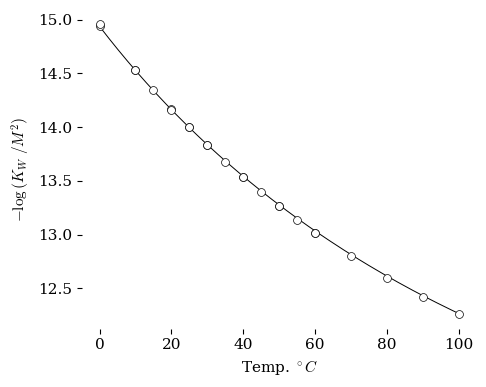

In [14]:
# https://srd.nist.gov/JPCRD/jpcrd181.pdf
# https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit


################################################################################
### Read data set. The fields are separated by tabs; comments are enabled  ###
################################################################################
df_pw = pd.read_csv("data/CRC_Water_Density.txt",    # dataset from the CRC handbook
                 delimiter = "\t",                   # this data was tab-delimited
                 skipinitialspace=True, 
                 comment = "#") 
display(df_pw.head())

################################################################################
### Read experimental data set. The fields are separated by commas; comments are enabled  ###
################################################################################
df_exp = pd.read_csv("data/IAPWS_processed.csv",    # processed data from 2024 IAPWS report
                 delimiter = ",",                   # this data was comma-delimited
                 skipinitialspace=True, 
                 comment = "#") 
display(df_exp.head())

# Data from AIPWS report 2024
Temp_exp = df_exp["t (°C)"] + 273.15
pKw_exp = df_exp["pKw(exp.)"]
pKw_err = df_exp["u[pKw(exp.)]"]

# Empirical equation from https://srd.nist.gov/JPCRD/jpcrd181.pdf
def NISTpKw(T, pw):
      A = -4.098; B = -3245.2; C = 2.2362E5; D = -3.984E7
      E = 13.957; F = -1262.3; G = 8.5641E5
            
      logKwCalcNIST = A + B/T + C/T**2 + D/T**3 + (E + F/T + G/T**2)*np.log10(pw)
      pKwCalcNIST = -logKwCalcNIST

      return(pKwCalcNIST)

T = df_pw["temp"]+273.15      # temperature values from the density table
pw = df_pw["density"]

pKwCalcNIST = NISTpKw(T,pw)

################################################################################
### Plot the data and the line fit.   
################################################################################
plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  


#ax.plot(T, logKwCalcNISTnoPressure, color='black', zorder=1, linestyle = "--", linewidth=0.4)
ax.plot(T - 273.15, pKwCalcNIST, color='black', zorder=1, linewidth=0.7)

ax.scatter(Temp_exp - 273.15, pKw_exp, 
           marker = "o", s=32, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3)

ax.set(ylabel=r"$-\log{(K_W\ /M^{2})}$", 
       xlabel=r"Temp. $^\circ C$",
#           xlim=[-0.01,0.35],                  
#          ylim=[-1.25,-0.7]
      
      )

################################################################################
### Plot the data and the line fit.   
################################################################################

temp = 25
Tt=temp + 273.15
line = df_pw.loc[df_pw["temp"]==temp]
pwt = line["density"]

# vertical line at temperature of interest
#ax.axvline(temp, linewidth = 0.4, color = "lightgray", zorder=0)

pKwCalcNIST1 = NISTpKw(Tt,pwt)

KW_temp = float(pKwCalcNIST1.iloc[0]) # convert series to float
print(f"pKw (molal) at {temp:0.1f} deg is {KW_temp:0.3f}")

KW_temp = 10**-KW_temp
conversion = (1/pwt)**2
KW_temp = KW_temp * conversion
KW_temp = -np.log10(KW_temp)
KW_temp = float(KW_temp.iloc[0]) # convert series to float
print(f"pKw (Molar)at {temp:0.1f} deg is {KW_temp:0.3f}")




plt.savefig("plots/KW_plot1.pdf")
plt.show()

### Same Plot with Residuals

Below we take the same results from the plot above and also plot the residuals

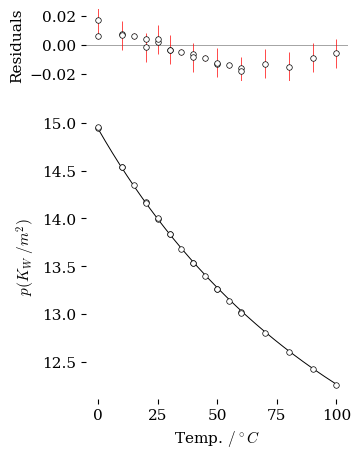

In [15]:
pw_exp = df_exp["ρw (g cm-3)"] 
res_NIST = NISTpKw(Temp_exp,pw_exp) - pKw_exp
res_AIPSW = NISTpKw(Temp_exp,pw_exp) - pKw_exp


residuals = -res_NIST      
datatemp = Temp_exp
dataKW = pKw_exp
dataerr = pKw_err
######################
### Plots - NEW STYLED PLOTTING SECTION from 03B-Eyring_Exercises_2_curvefit.ipynb
######################

plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")     ### Then add a fancy style sheet   
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[4,5], height_ratios=[1, 4])  

# Settings for plot
ax[1].set(ylabel=r"$p{(K_W\ /m^{2})}$", 
       xlabel=r"Temp. $/^\circ C$",
#       xlim=[-0.01,0.35],                  
#       ylim=[-1.25,-0.7]  
       )
### Data graphics
ax[1].scatter(datatemp-273.15, dataKW, 
           marker = "o", s=16, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3) 

ax[1].errorbar(datatemp-273.15, dataKW, dataerr*2, marker = None,
            ecolor = "red", elinewidth = 0.5, capsize = 0,
            linewidth = 0, zorder = 2)

#ax[1].plot(T-273.15, pKwCalcAIPWS, color='blue', zorder=1, linewidth=0.7)
#ax[1].plot(T-273.15, pKwCalcNIST, color='green', zorder=1, linewidth=0.7)

######################
### Plot the residuals
######################

# difference between data and line-fit

ax[0].set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[-0.3, 7.1],                  
          ylim=[-0.0245,+0.0245]
       )
### Data graphics
ax[0].scatter(datatemp - 273.15, residuals, marker = "o", s = 16, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
ax[0].errorbar(datatemp - 273.15, residuals, dataerr*2, marker = None,
            ecolor = "red", elinewidth = 0.5, capsize = 0,
            linewidth = 0, zorder = 2)

ax[0].axhline(0, color='gray', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])

####################################################
### Plot original author's line on main plot and in residuals
####################################################
ax[1].plot(T - 273.15, pKwCalcNIST, color='black', zorder=1, linewidth=0.7)

#ax[0].plot(T-273.15, res_NIST*1, color = "green", alpha = 0.5, linewidth = 0.7, zorder = 1)
#ax[0].plot(T-273.15, res_AIPWS*1, color = "blue", alpha = 0.5, linewidth = 0.7, zorder = 1)


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/KW_plot2.pdf")
plt.show()

## Using the IAPWS Equation from 2024

Using the empirical equation from IAPWS release of 2024

### The Model

The IAPWS 2024 model for $pK_W$ is described in the handout that accompanies this notebook. It is implemented as the function `AIPWSpKw(T,pw)` in the code below. The function takes an array of temperatures and a corresponding array of densities and returns an array of $pK_W$ values.

## Density data from CRC

,row,temp,density
0,1,0.1,0.999849
1,2,0.2,0.999856
2,3,0.3,0.999862
3,4,0.4,0.999869
4,5,0.5,0.999874


,Unnamed: 0,Source,t (°C),ρw (g cm-3),pKw(exp.),u[pKw(exp.)],pKw(fit),ΔpKw,Diff.
0,90,Harned and Robinson (1940)49,0.0,0.9998,14.944,0.001,14.947,-0.003,-0.002
1,92,Harned and Robinson (1940)49,10.0,0.9997,14.535,0.001,14.534,0.001,0.000
2,93,Harned and Robinson (1940)49,15.0,0.9991,14.346,0.001,14.344,0.002,-0.001
3,94,Harned and Robinson (1940)49,20.0,0.9982,14.167,0.001,14.165,0.002,-0.001
4,95,Harned and Robinson (1940)49,25.0,0.9970,13.997,0.001,13.994,0.002,-0.001


pKw (molal) at 25.0 deg is 13.994
pKw (Molar)at 25.0 deg is 13.992


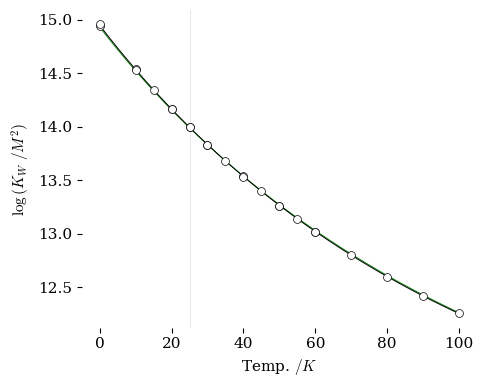

In [24]:
# https://srd.nist.gov/JPCRD/jpcrd181.pdf
# https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit


################################################################################
### Read data set. The fields are separated by tabs; comments are enabled  ###
################################################################################
df_pw = pd.read_csv("data/CRC_Water_Density.txt",    # dataset from the CRC handbook
                 delimiter = "\t",                   # this data was tab-delimited
                 skipinitialspace=True, 
                 comment = "#") 
display(df_pw.head())

################################################################################
### Read experimental data set. The fields are separated by commas; comments are enabled  ###
################################################################################
df_exp = pd.read_csv("data/IAPWS_processed.csv",    # processed data from 2024 IAPWS report
                 delimiter = ",",                   # this data was comma-delimited
                 skipinitialspace=True, 
                 comment = "#") 
display(df_exp.head())

# Data from AIPWS report 2024
Temp_exp = df_exp["t (°C)"] + 273.15
pKw_exp = df_exp["pKw(exp.)"]
pKw_err = df_exp["u[pKw(exp.)]"]


# Empirical equation from https://srd.nist.gov/JPCRD/jpcrd181.pdf
def AIPWSpKw(T,pw):
    a0 = -0.702132; a1 = 8681.05; a2 = -24145.1
    b0 = 0.813876; b1 = -51.4471; b2 = -0.469920
    n = 6
    mw = 18.015268
    
    pKwG = 0.61416 + 48251.33/T - 67707.93/T**2 + 10102100/T**3
    Z = pw * np.exp(a0 + a1/T + a2/T**2 * np.power(pw, (2/3)))
    pKwCalcAIPWS = -2*n * (np.log10(1+Z) - Z/(Z+1) * pw * (b0 + b1/T + b2*pw)) + pKwG + 2*np.log10(mw/1000)

    return(pKwCalcAIPWS)

T = df_pw["temp"]+273
pw = df_pw["density"]
pKwCalcAIPWS = AIPWSpKw(T,pw)

################################################################################
### Plot the data and the line fit.   
################################################################################
plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

ax.plot(T-273.15, pKwCalcNIST, color='green', zorder=1, linewidth=0.7)
ax.plot(T-273.15, pKwCalcAIPWS, color='black', zorder=1, linewidth=0.7)

ax.scatter(Temp_exp-273.15,pKw_exp, 
           marker = "o", s=32, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3)

ax.set(ylabel=r"$\log{(K_W\ /M^{2})}$", 
       xlabel=r"Temp. $/K$",
#           xlim=[-0.01,0.35],                  
#          ylim=[-1.25,-0.7]  
      )

temp = 25
Tt = temp + 273.15
line = df_pw.loc[df_pw["temp"]==temp]
pwt = line["density"]

pKwCalcAIPWS2 = AIPWSpKw(Tt,pwt)

KW_temp = float(pKwCalcAIPWS2.iloc[0]) # convert series to float
print(f"pKw (molal) at {temp:0.1f} deg is {KW_temp:0.3f}")

KW_temp = 10**-KW_temp
conversion = (1/pwt)**2
KW_temp = KW_temp * conversion
KW_temp = -np.log10(KW_temp)
KW_temp = float(KW_temp.iloc[0]) # convert series to float

print(f"pKw (Molar)at {temp:0.1f} deg is {KW_temp:0.3f}")

ax.axvline(temp, linewidth = 0.4, color = "lightgray", zorder=0)

plt.savefig("plots/KW_plot3.pdf")
plt.show()

### Same Plot with Residuals

Below we take the same results from the plot above and also plot the residuals

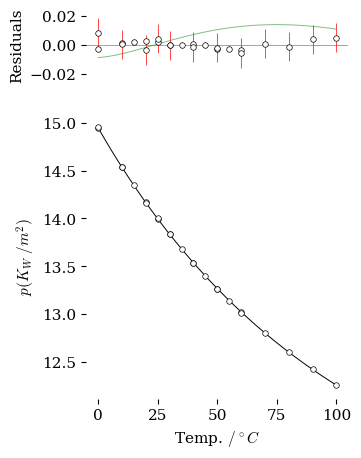

In [27]:
pw_exp = df_exp["ρw (g cm-3)"] 
res_NIST = NISTpKw(T,pw) - AIPWSpKw(T,pw)

#res_AIPSW = AIPWSpKw(Temp_exp,pw_exp) - pKw_exp
res_AIPSW = AIPWSpKw(Temp_exp,pw_exp) - pKw_exp


residuals = -res_AIPSW      
datatemp = Temp_exp
dataKW = pKw_exp
dataerr = pKw_err
######################
### Plots - NEW STYLED PLOTTING SECTION from 03B-Eyring_Exercises_2_curvefit.ipynb
######################

plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")     ### Then add a fancy style sheet   
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[4,5], height_ratios=[1, 4])  

# Settings for plot
ax[1].set(ylabel=r"$p{(K_W\ /m^{2})}$", 
       xlabel=r"Temp. $/^\circ C$",
#       xlim=[-0.01,0.35],                  
#       ylim=[-1.25,-0.7]  
       )
### Data graphics
ax[1].scatter(datatemp-273.15, dataKW, 
           marker = "o", s=16, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3) 

ax[1].errorbar(datatemp-273.15, dataKW, dataerr*2, marker = None,
            ecolor = "red", elinewidth = 0.5, capsize = 0,
            linewidth = 0, zorder = 2)

ax[1].plot(T-273.15, pKwCalcAIPWS, color='black', zorder=1, linewidth=0.7)
#ax[1].plot(T-273.15, pKwCalcNIST, color='green', zorder=1, linewidth=0.7)

######################
### Plot the residuals
######################

# difference between data and line-fit

ax[0].set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[-0.3, 7.1],                  
          ylim=[-0.0245,+0.0245]
       )
### Data graphics
ax[0].scatter(datatemp - 273.15, residuals, marker = "o", s = 16, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
ax[0].errorbar(datatemp - 273.15, residuals, dataerr*2, marker = None,
            ecolor = "red", elinewidth = 0.5, capsize = 0,
            linewidth = 0, zorder = 2)

ax[0].axhline(0, color='gray', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])

####################################################
### Plot original author's line on main plot and in residuals
####################################################
#ax[1].plot(T - 273.15, pKwCalcNIST, color='black', zorder=1, linewidth=0.7)

ax[0].plot(T-273.15, res_NIST*1, color = "green", alpha = 0.5, linewidth = 0.7, zorder = 1)
#ax[0].plot(T-273.15, res_AIPWS*1, color = "blue", alpha = 0.5, linewidth = 0.7, zorder = 1)


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/KW_plot2.pdf")
plt.show()

## Process AIPWS experimental database

In [28]:
# https://srd.nist.gov/JPCRD/jpcrd181.pdf
# https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit


################################################################################
### Read data set. The fields are separated by commas; comments are enabled  ###
################################################################################
df_d = pd.read_csv("data/IAPWS_Dataset.txt", 
                 delimiter = "\t", 
                 skipinitialspace=True, 
#                 index_col="pH", 
                 comment = "#") 
#display(df2)

# SELECT DATA

df_d = df_d.loc[df_d["t (°C)"] < 101]       # select onlybtemperatures below 101 deg C
df_d = df_d.loc[df_d["ρw (g cm-3)"] < 1]    # select only densities under 1 g/cm
df_d = df_d.loc[df_d["u[pKw(exp.)]"] < 0.0051]    # select only high precission data sets

#display(df_d)
#df_d.to_csv("data/IAPWS_processed.csv")

## Polynomial Curve Fit

,row,temp,density
0,1,0.1,0.999849
1,2,0.2,0.999856
2,3,0.3,0.999862
3,4,0.4,0.999869
4,5,0.5,0.999874


,Unnamed: 0,Source,t (°C),ρw (g cm-3),pKw(exp.),u[pKw(exp.)],pKw(fit),ΔpKw,Diff.
0,90,Harned and Robinson (1940)49,0.0,0.9998,14.944,0.001,14.947,-0.003,-0.002
1,92,Harned and Robinson (1940)49,10.0,0.9997,14.535,0.001,14.534,0.001,0.000
2,93,Harned and Robinson (1940)49,15.0,0.9991,14.346,0.001,14.344,0.002,-0.001
3,94,Harned and Robinson (1940)49,20.0,0.9982,14.167,0.001,14.165,0.002,-0.001
4,95,Harned and Robinson (1940)49,25.0,0.9970,13.997,0.001,13.994,0.002,-0.001


(-4.760228633547518e-07+/-2.0033657410443902e-08, 0.0005962350891486912+/-1.8853294110197196e-05, -0.2619096434500834+/-0.005900071533056763, 51.69960671460004+/-0.6139096001889802)


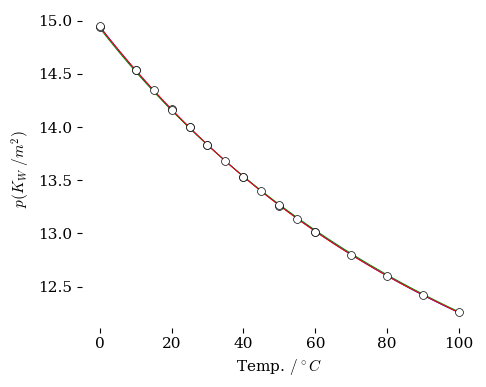

In [30]:
################################################################################
### Read data set. The fields are separated by tabs; comments are enabled  ###
################################################################################
df_pw = pd.read_csv("data/CRC_Water_Density.txt",    # dataset from the CRC handbook
                 delimiter = "\t",                   # this data was tab-delimited
                 skipinitialspace=True, 
                 comment = "#") 
display(df_pw.head())

################################################################################
### Read experimental data set. The fields are separated by commas; comments are enabled  ###
################################################################################
df_exp = pd.read_csv("data/IAPWS_processed.csv",    # processed data from 2024 IAPWS report
                 delimiter = ",",                   # this data was comma-delimited
                 skipinitialspace=True, 
                 comment = "#") 
display(df_exp.head())

# Data from AIPWS report 2024
Temp_exp = df_exp["t (°C)"] + 273.15
pKw_exp = df_exp["pKw(exp.)"]
pKw_err = df_exp["u[pKw(exp.)]"]


df2 = pd.read_csv("data/IAPWS_processed.csv", 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="pH", 
                 comment = "#") 
#display(df2)

result = np.polyfit(Temp_exp, pKw_exp, deg=3, rcond=None, full=False, w=1/pKw_err, cov=True)
[popt,pcov] = result

popt_u = un.correlated_values(popt,pcov)
print(popt_u)

# make function from parameters
predict = np.poly1d(popt)

#x=np.linspace(0+273, 100+273, 100)
x = T   # use values from density table to match arrays for pKwCalcAIPWS and pKwCalcNIST
y = predict(x)

################################################################################
### Plot the data and the line fit.   
################################################################################
plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  


ax.plot(T-273.15, pKwCalcAIPWS, color='blue', zorder=1, linewidth=0.7)
ax.plot(T-273.15, pKwCalcNIST, color='green', zorder=1, linewidth=0.7)

ax.plot(x-273.15, y, color='red', zorder=1, linewidth=0.7)

ax.scatter(Temp_exp-273.15, pKw_exp, 
           marker = "o", s=32, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3)

ax.errorbar(Temp_exp-273.15, pKw_exp, pKw_err*2, marker = None,
            ecolor = "red", elinewidth = 0.5, capsize = 0,
            linewidth = 0, zorder = 2)


ax.set(ylabel=r"$p{(K_W\ /m^{2})}$", 
       xlabel=r"Temp. $/^\circ C$",
#           xlim=[-0.01,0.35],                  
#          ylim=[-1.25,-0.7]  
      )
#ax.axvline(17+273.15, linewidth = 0.4, color = "lightgray", zorder=0)




plt.savefig("plots/KW_plot.pdf")
plt.show()

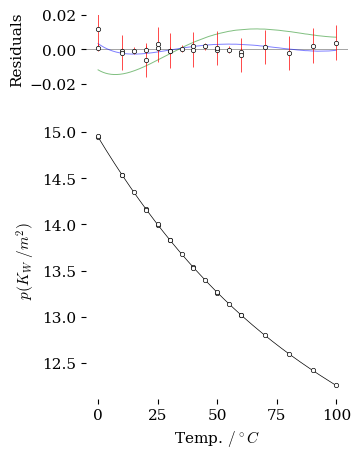

In [7]:
res_NIST = pKwCalcNIST - y
res_AIPWS = pKwCalcAIPWS - y

res = predict(datatemp) - dataKW

######################
### Plots - NEW STYLED PLOTTING SECTION from 03B-Eyring_Exercises_2_curvefit.ipynb
######################

plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")     ### Then add a fancy style sheet   
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[4,5], height_ratios=[1, 4])  

# Settings for plot
ax[1].set(ylabel=r"$p{(K_W\ /m^{2})}$", 
       xlabel=r"Temp. $/^\circ C$",
#       xlim=[-0.01,0.35],                  
#       ylim=[-1.25,-0.7]  
       )
### Data graphics
ax[1].scatter(Temp_exp-273.15, pKw_exp, 
           marker = "o", s=10, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3) 

ax[1].errorbar(Temp_exp-273.15, pKw_exp, pKw_err*2, marker = None,
            ecolor = "red", elinewidth = 0.5, capsize = 0,
            linewidth = 0, zorder = 2)

ax[1].plot(x-273.15, y, 
           color = "black", linewidth = 0.5, 
           zorder = 1)


######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = -res      

ax[0].set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[-0.3, 7.1],                  
          ylim=[-0.02,+0.02]
       )
### Data graphics
ax[0].scatter(Temp_exp-273.15, residuals, marker = "o", s = 10, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
ax[0].errorbar(Temp_exp-273.15, residuals, pKw_err*2, marker = None,
            ecolor = "red", elinewidth = 0.5, capsize = 0,
            linewidth = 0, zorder = 2)

ax[0].axhline(0, color='gray', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])

####################################################
### Plot original author's line on main plot and in residuals
####################################################

ax[0].plot(T-273.15, res_NIST*1, color = "green", alpha = 0.5, linewidth = 0.7, zorder = 1)
ax[0].plot(T-273.15, res_AIPWS*1, color = "blue", alpha = 0.5, linewidth = 0.7, zorder = 1)


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/polynomialfit.pdf")
plt.show()



## A Tool to calulate $pK_W$

The simple polynomial fit of data between zero and 100 $^\circ C$ was just as good as the AIPWS 2024 model. The Marshall \& Franck 1981 model was also excellent (the deviations observed, although systematic, we tiny). Which shall you choose?

For calculating the value of $pK_W$ at eny temperature that is in the CRC handbook tables for water density we will use the AIPWS model as demonstrated in the code below. Set a temperture and then get the result. This code requires the presence of a file containing water densities vs temperature. Other than that the code below is complete (does not require any other blocks in this notebook to be run previously) and portable.

In [39]:
import pandas as pd
import numpy as np

################################################################################
### Set temperture here and then run this code
################################################################################

temp = 25


################################################################################
### Read data set. The fields are separated by tabs; comments are enabled  
################################################################################
df_pw = pd.read_csv("data/CRC_Water_Density.txt",    # dataset from the CRC handbook
                 delimiter = "\t",                   # this data was tab-delimited
                 skipinitialspace=True, 
                 comment = "#") 
#display(df_pw.head())

Temp_exp = df_exp["t (°C)"]
pKw_exp = df_exp["pKw(exp.)"]

################################################################################
# Empirical equation from https://srd.nist.gov/JPCRD/jpcrd181.pdf
################################################################################

def AIPWSpKw(T,pw):
    a0 = -0.702132; a1 = 8681.05; a2 = -24145.1
    b0 = 0.813876; b1 = -51.4471; b2 = -0.469920
    n = 6
    mw = 18.015268
    
    pKwG = 0.61416 + 48251.33/T - 67707.93/T**2 + 10102100/T**3
    Z = pw * np.exp(a0 + a1/T + a2/T**2 * np.power(pw, (2/3)))
    pKwCalcAIPWS = -2*n * (np.log10(1+Z) - Z/(Z+1) * pw * (b0 + b1/T + b2*pw)) + pKwG + 2*np.log10(mw/1000)

    return(pKwCalcAIPWS)

################################################################################
# Use function to calculate pKw
################################################################################

line = df_pw.loc[df_pw["temp"]==temp]  # pick the data line where the temp exists
pw = line["density"]                  # pick density out of that line

pKwCalcAIPWS2 = AIPWSpKw(temp+273.15, pw)

################################################################################
# Print results
################################################################################

KW_temp = float(pKwCalcAIPWS2.iloc[0]) # convert series to float
print(f"pKw (molal) at {temp:0.1f} deg is {KW_temp:0.3f}")

KW_temp = 10**-KW_temp
conversion = (1/pwt)**2    # convert kg to litres using density
KW_temp = KW_temp * conversion
KW_temp = -np.log10(KW_temp)
KW_temp = float(KW_temp.iloc[0]) # convert series to float (density was a series)
print(f"pKw (Molar) at {temp:0.1f} deg is {KW_temp:0.3f}")

pKw (molal) at 25.0 deg is 13.994
pKw (Molar) at 25.0 deg is 13.992


## A Universal Model?

The model above for calculating the value of $pK_a$ will only work if we have a value for density at that temperature. The CRC and the NIST databases clearly are reporting density values that are calculated from a model that they do not document. Perhaps we could reverse-engineer the model using a polynomial fit and then use that modl that predicts density vs temperture as a 4\textsuperscript layer to the AIPWS model.

Such a model would not need a database of sensities to work. I will leave that as an exercise for the reader. The CRC lists all temperatures between zero and 100 in increments of single degrees (and tenths of a degree between 0 and 60) so the model above that needs the database will be good enough for me.